- Name: Benjamin Makowsky
- PID: A14726324
- COGS118C - Assignment 4

# This notebook has [45 + 5 Bonus] points in total 
##### The number of points for each question is denoted by []. Make sure you've answered all the questions and that the point total add up.

# Lab 4 - Hilbert Transform, Cross-Frequency, and Spike-Field Analysis

This lab will cover the basis of a range of analysis that neuroscientists perform regularly, combining spiking and LFP data. First, we will use the Hilbert transform to compute the time-resolved (complex) analytic signal for a narrowband oscillation in the LFP, and its instantaneous power and phase. Then, we'll look at coupling of phase and amplitude across frequencies. Finally, we will introduce spike trains, the (smoothed) firing rate vector, and a couple of spike-LFP analyses. By the end of this lab, you should have the theoretical understanding and practical know-how to start working in most human or animal electrophysiology labs!

Key concepts:

- Hilbert transform of filtered signals
- Instantaneous amplitude and phase
- Cross-frequency coupling
- Spike-train analysis
- Spike-field coherence
- Binned firing rate
- Rate-power correlation

**Note: in this lab, the written responses are entered in the cell immediately below the question, so that when you write your response, it doesn't screw up the formatting of the question. Thank you for this suggestion.** 

In [1]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal # we will also import the signal module, from scipy

# [3] Q1: Hilbert Transform & Analytic Signals
As we discussed in class, the Hilbert Transform retrieves the **analytic signal** from the real valued signal. In Lab 3, we explored the symmetry property of the DFT for real-valued signals. In brief, a real-valued sinusoid is the summation of two complex sinusoids (exponentials) at the same frequency, but with opposite signs. In other words, it's the sum of a complex conjugate pair. We will first demonstrate this with a simple sinusoid.

[1] 1.1: For a 1-second window of real-valued sinusoid at 14Hz, which DFT coefficients are not zero? You may answer in terms of frequency (Hz) or wavenumber (k).

[1] 1.2: Compute the FFT of the sine wave below, and plot the real and imaginary spectrum as a function of frequency. Zoom into -20 to 20 Hz.

[1] 1.3: Comment on the similarities and differences in the real and imaginary coefficent plots.

**Response for 1.1:** -14 and 14 hz

**Response for 1.3:** The peaks are at the same spot but the negaive is inverted for the imaginary values

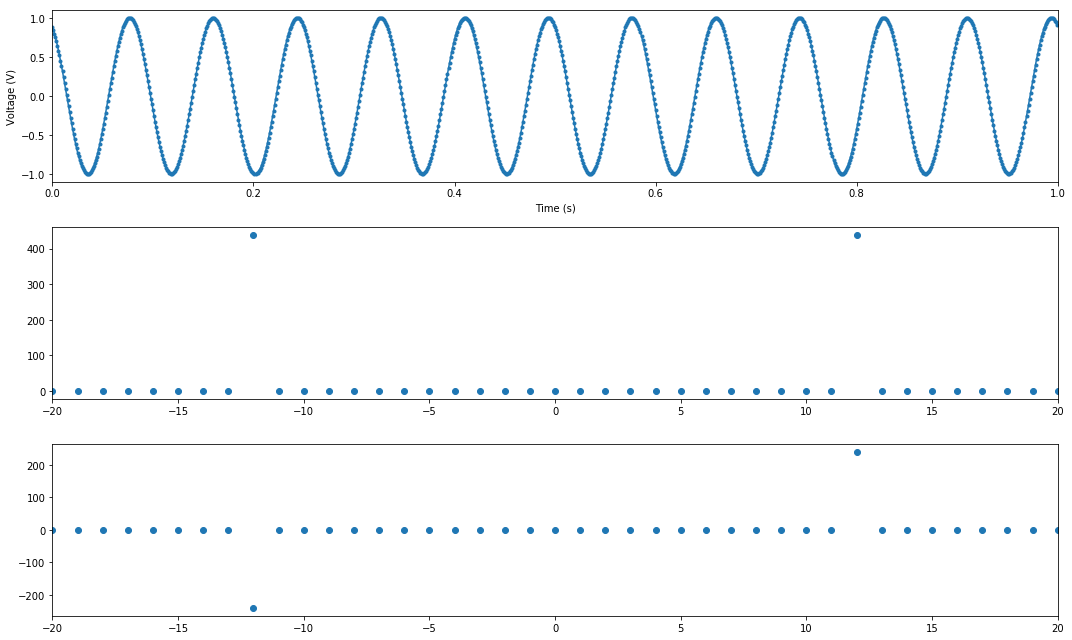

In [2]:
T, fs = 1, 1000
f_sin = 12 #Hz
t = np.arange(0,T,1/fs)
# make a sine wave
offset = 0.5
sine = np.cos(2*np.pi*f_sin*t+offset)

# plot it
plt.figure(figsize=(15,9))
plt.subplot(3,1,1)
plt.plot(t,sine, '.-')
plt.xlim([0,1])
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');

# compute and plot FFT coefficients
FT = np.fft.fft(sine)
freqs = np.fft.fftfreq(t.size, 1/fs)

plt.subplot(3,1,2)
# plot DFT real components
plt.plot(freqs, FT.real, 'o')
plt.xlim(-20,20)


plt.subplot(3,1,3)
# plot DFT imaginary components
plt.plot(freqs,FT.imag , 'o')
plt.xlim(-20,20)


plt.tight_layout()

# [7] Q1 - Continued

The Hilbert transform, as implemented in `scipy.signal`, takes the FFT of the signal, deletes the negative frequencies, and doubles the positive frequencies. In essence, it retrieves the analytic signal by erasing the negative frequency component of the real-valued signal, leaving just the positive frequency from the complex conjugate pair. We'll achieve this in 3 different ways below.

![](./img/sp_hilbert.png)

[1] 1.4: Write out the expression for the complex exponential corresponding to the positive one you see in the figure above (refer to the DFT formula if you forgot). It's the same expression as the DFT complex exponential, making use of your response for Q1.1. You can express it in either frequency or wavenumber, and you can ignore the phase offset in the sine expression.

[1] 1.5: I have created the complex exponential for you in code below (`complex_sine`). This is a vector of complex numbers. If you try to plot this directly, it will plot only the real component. Plot both the real and imaginary components in the same figure, and label the traces. Zoom into the 0 to 1 second (for this and the next 2 questions).

[1] 1.6: Compute the analytic signal of `sine` using `signal.hilbert()`, and store it in the variable `x_a`. In the second panel of the figure, plot the real and imag components in the same plot. It should look identical to the plot from 1.5.

[3] 1.7: Complete the function `my_hilbert()` below to create your own Hilbert transform, following the expression provided in `signal.hilbert()` documentation above. Note that your function should compute and return the **analytic signal**, not the Hilbert Transform itself. Hint: `np.where()` will probably be helpful for finding negative frequencies.

[1] 1.8: Use your function to compute the analytic signal of `sine`, as you did for Q1.6. Plot the real and imaginary components. You should have 3 identical plots at this point.

**Response for 1.4:** e^(2i\*pi\*sint) 

Text(0.5, 0, 'Time t')

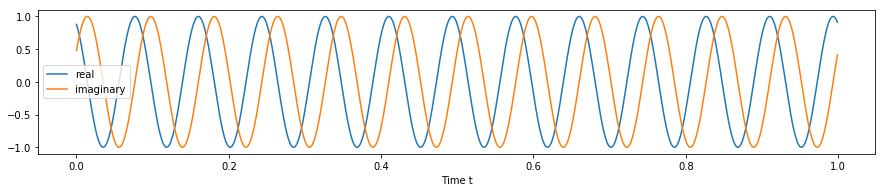

In [3]:
complex_sine = np.exp(1j*(2*np.pi*f_sin*t+offset))

plt.figure(figsize=(15,9))
plt.subplot(3,1,1)
plt.plot(t,complex_sine.real, label="real")
plt.plot(t,complex_sine.imag,label="imaginary")
plt.legend(); plt.xlabel("Time t")

# plot the real and imag component of complex_sine

Text(0.5, 0, 'Time t')

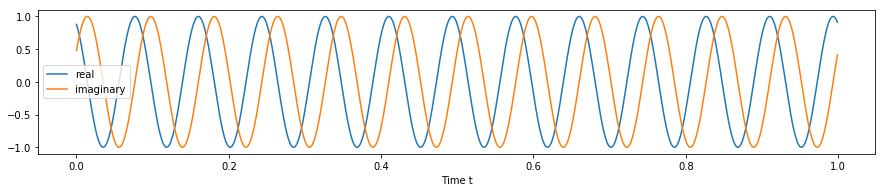

In [4]:
# call signal.hilbert and plot the real and imag component of x_a
x_a = signal.hilbert(complex_sine.real)
plt.figure(figsize=(15,9))
plt.subplot(3,1,2)
plt.plot(t,x_a.real, label="real")
plt.plot(t,x_a.imag,label="imaginary")
plt.legend(); plt.xlabel("Time t")
# plot real and im component of x_a

Text(0.5, 0, 'Time t')

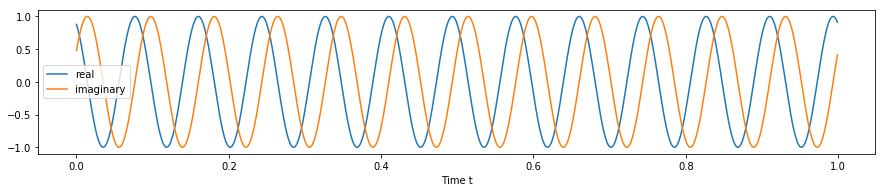

In [9]:
def my_hilbert(signal):
    N = signal.size
    FT = np.fft.fft(signal)
    FT[np.where(freqs<0)] = 0
    x = np.fft.ifft(FT)
    return x

plt.figure(figsize=(15,9))
plt.subplot(3,1,3)
# call my_hilbert and plot the real and imag component of my_x_a
my_x_a = my_hilbert(complex_sine)
plt.plot(t,my_x_a.real, label="real")
plt.plot(t,my_x_a.imag,label="imaginary")
plt.legend(); plt.xlabel("Time t")

---
# Now let's try it on some real brain signals
We'll be using the same LFP data again, recorded in the rat hippocampus. But later on in this lab, we will use the spike train for the first time. We will use a slightly longer snippet of data to start (`lfp_short`, 2min), for the purpose of demonstrating the Hilbert transform.

In [10]:
data = io.loadmat('./data/LFP.mat', squeeze_me=True)
print(data.keys())

# unpack the variables
fs = data['fs'] # sampling rate 
print('Sampling rate = %iHz'%fs)

lfp = data['lfp'][0,:]/1000 # this file contains two channels, we'll only work with the first one
lfp_short = lfp[:int(120*fs)] # make a variable that has only the first two seconds of the LFP
t_short = np.arange(0, len(lfp_short)/fs, 1/fs) # create the corresponding time vector

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'fs', 'spike_indices', 'spike_fs'])
Sampling rate = 1250Hz


# [6] Q2: Instantaneous Power and Phase
Now that you can computed the analytic signal, you can apply it on real data to compute its instantaneous power and phase, which are a lot more interesting. But first, we have to filter the signal to constrain the signal bandwidth to our frequency range of interest. Zoom into the first 2 seconds of the data for all the plots below.

[1] Q2.1: Use `signal.firwin()` to design a 751-point bandpass filter that has a passband of 4-10Hz. Store the coefficients in the variable `FIR_theta`.

[1] Q2.2: Use `np.convolve()` to filter the LFP signal, `lfp_short`, and store it in the variable `theta_osc`. Plot both the original and bandpass filtered signal in the same plot. Zoom into the first 2 seconds. Label the traces and axes, the filtered signal should look like a smooth version of the original.

[1] Q2.3: Compute the analytic signal of the filtered oscillation, and plot the real and imaginary components of it in the same plot. You may use either `sp.hilbert()` or `my_hilbert()`, and you may want to see that the plot looks the same regardless of which you use to confirm that `my_hilbert()` is doing the right thing.

[2] Q2.4: The instantaneous power and phase of the signal is the same idea as the power and phase of your DFT. It uses the exact same formula, just at a much higher time resolution (every time point). Complete the function `compute_power_phase()` below that takes in an analytic signal and returns the **power** and **phase**. Recall that power is the amplitude squared.

[1] Q2.5: Use your function to find the instantaneous power and phase (`theta_power` and `theta_phase`) of the analytic signal of the filtered LFP, and plot them in two different plots. Zoom into the first 2 seconds and remember the appropriate labels. Your power plot should look very smooth, while the phase plot should look like a sawtooth.

[BONUS 1] Q2.6: At which time point (roughly) is the oscillation frequency the highest? Explain your answer. Hint: look at how the phase advances, and remember the definition of instananeous frequency.

**Response for 2.6:** Right before .75 seconds because that has the steepest slope

In [11]:
low = 4
high = 10
ntaps = 751
nyquist = fs / 2
FIR_theta = signal.firwin(ntaps,[low,high],nyq=nyquist,pass_zero=False)

(Text(0.5, 0, 'Time t'), Text(0, 0.5, 'Angle'))

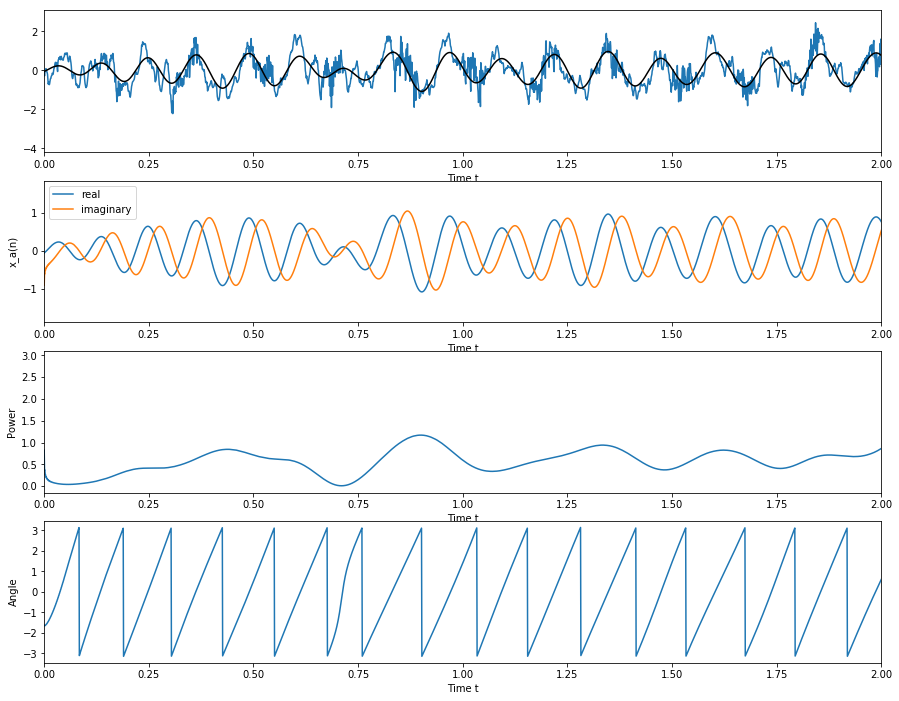

In [15]:
theta_osc = np.convolve(lfp_short,FIR_theta, mode='same')
x_a_theta = signal.hilbert(theta_osc)
#mine = my_hilbert(theta_osc)
def compute_power_phase(x_a):
    power = abs(x_a)**2
    phase = (np.angle(x_a))
    return power, phase

theta_power, theta_phase = compute_power_phase(x_a_theta)


plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.subplot(4,1,1)
plt.plot(t_short, lfp_short,label="unfiltered")
plt.plot(t_short,theta_osc, color='black',label='filtered')
plt.xlim(0,2);plt.xlabel('Time t')

# plot the real and imaginary components of the analytic signal
plt.subplot(4,1,2)
plt.plot(t_short,x_a_theta.real,label='real')
plt.plot(t_short,x_a_theta.imag,label='imaginary')
plt.xlim(0,2);plt.xlabel('Time t');plt.ylabel('x_a(n)');plt.legend()

# plot the instantaneous power 
plt.subplot(4,1,3)
plt.plot(t_short, theta_power)
plt.xlim(0,2);plt.xlabel('Time t'),plt.ylabel('Power');plt.ylim()


# plot the instantaneous phase
plt.subplot(4,1,4)
plt.plot(t_short, theta_phase)
plt.xlim(0,2);plt.xlabel('Time t'),plt.ylabel('Angle')

---
![](./img/polar.png)
Following the same principle, we used the Hilbert above transform to find the analytic signal for the segment of LFP, then retrieved its instantaneous power and phase (sometimes called analytic power and phase). Remember, the power and phase correspond to the magnitude (squared) and phase angle of the vector in the complex plane at every time point, which is the only way power and phase are defined. It may be a bit hard to keep track of these abstract quantities, so we will see below how they are used in real-life situations in the context of a neuroscience experiment.

# [10 + 2 Bonus] Q3: Phase Amplitude Coupling (Canolty et al., 2006)
There are often multiple oscillations present in a brain recording, at the same time. In Canolty et al., 2006, the authors explore phase-amplitude coupling between theta (4-8Hz) and gamma (100-150Hz) oscillations. We will have discussed this paper in class. To summarize, the finding is that **the phase of the slow oscillation, i.e., whether it's at the peak or trough of its cycle, is systematically related to the power of the faster oscillation.** There is a huge amount of literature stemming from this work, positing that the slow oscillation is acting like a periodically-opening gate that modulates the fast oscillation, which carries the information content, akin to how an amplitude-modulated (AM) radio works. We won't examine the theory too closely here, but I will guide you through the steps of reproducing this analysis in the rat LFP, which also happens to exhibit theta-gamma phase amplitude coupling, but at a different gamma frequency.

---
** In all the plotting questions for this part, use `'.'` in `plt.plot()` to denote point markers.** If you don't know how, refer to previous assignments where I do that for you, or read the documentation.

[3] 3.1: We have already computed theta power and phase above. We need to do the same, but for gamma power. Create a 251-point filter with a passband of 30-50Hz, and filter the lfp signal `lfp_short`. Then, compute the instantaneous power and phase of your filtered gamma oscillation. You can copy the same snippet of code above, but be careful to change the variables correspondingly (everywhere from `theta` to `gamma`).

[1] 3.2: On the same plot, plot the first 2 seconds of theta phase and gamma power. Label! To make them appear roughly the same scale, you will have to multiply your gamma power by about 4, **only when plotting**.

[1] 3.3: In Fig.1C of the paper, the authors split theta phase into peak and trough. In the complex plane (diagram above), if you were to divide the circle into two semicircles, where would you draw the line such that one half contains (and is centered at) the phase corresponding to the peaks of the oscillations, and the other half contains the trough of the oscillation? Which half corresponds to the peak phases? Hint: look at your plot for Q2.

[1] 3.4: I compute for you the indices that correspond to the peak half and trough half of the theta phase, respectively. In a new plot, use `peak_inds`, and `trough_inds` to plot the peak and trough phases separately (but in the same plot). They should segment your original phase plot into two different colors. Make sure that this matches your answer for Q3.3.

[1] 3.5: In the same plot as Q3.4, use `peak_inds`, and `trough_inds` to plot the gamma powers that correspond to the theta peak and trough phases separately. They should segment your original power plot into two different colors. After this step, this second plot should look identical to the first one, but with 4 different colors that separate the data according to theta peak and troughs.

[1] 3.6: We will try to reproduce the same histogram as Fig.1C of the paper, by using `plt.hist()`. To try to reproduce the finding exactly, we will compute the **amplitude distrbution, instead of the power distribution.** I have set up most of the code for you for plotting the histogram. You need to complete the call to `plt.hist()` such that it computes the distribution of **gamma amplitude** for those indices corresponding the theta peaks and troughs. This is the same as what you did in Q3.5, **but instead of power, transform it to get the amplitude**. Label the traces and axes appropriately.

[2] 3.7: What can you conclude from the histograms in Q3.6? How do they compare to Fig.1C in Canolty et al., 2006?

[BONUS 1] 3.8: Binning theta phase by peak vs. trough is one crude way to do it. Another way to visualize this is to plot the gamma amplitude by their corresponding theta phase. Produce a plot where the x-axis is theta phase and y-axis is gamma amplitude. Just by examining the plot visually, discuss whether this results in similar or different conclusions as Q3.7, and why.

[BONUS 1] 3.9: In the paper, the authors combine the theta phase and gamma amplitude time series into a single complex exponential time series, then compute the modulation index as the vector magnitude of the average complex vector over all time points. Reproduce this analysis, compute and print the modulation index value for the LFP data above, as well as the preferred phase. The modulation index should be about 0.0149.

**Response for 3.3:** I would draw it horizontally across the center so taht the top wa the peak and the bottom was the trough

**Response for 3.7:** The plots are very close in shape with just the power being different by a factor of 10 

**Response for 3.8:** ANSWER 

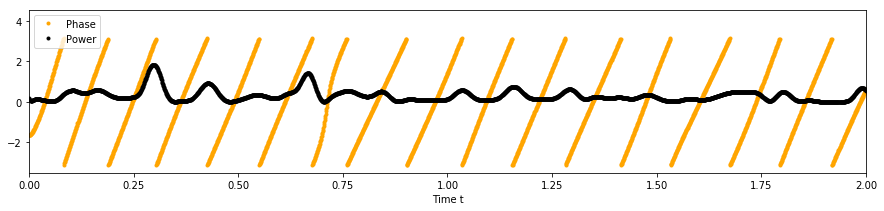

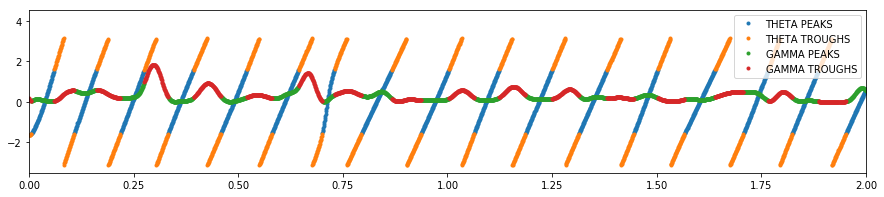

In [22]:
low = 30
high = 50
ntaps = 251
nyquist = fs / 2
# compute gamma power and phase
FIR_gamma = signal.firwin(ntaps,(low,high),fs=fs, pass_zero=False)
gamma_osc = np.convolve(lfp_short,FIR_gamma, mode='same')
x_a_gamma = signal.hilbert(gamma_osc)
gamma_power, gamma_phase = compute_power_phase(x_a_gamma)

# plot theta phase and gamma power
plt.figure(figsize=(15,3))

plt.plot(t_short, theta_phase,'.',label='Phase', color='orange')
plt.plot(t_short, gamma_power*4,'.',label='Power',color='black')
plt.xlim(0,2);plt.xlabel('Time t');plt.legend()

peak_inds = np.where(np.logical_and(theta_phase>-np.pi/2, theta_phase<np.pi/2))[0]
trough_inds = np.where(np.logical_or(theta_phase<-np.pi/2, theta_phase>np.pi/2))[0]

plt.figure(figsize=(15,3))

# plot the theta peak and trough phases
plt.plot(t_short[peak_inds], theta_phase[peak_inds], '.',label='THETA PEAKS')
plt.plot(t_short[trough_inds], theta_phase[trough_inds], '.', label='THETA TROUGHS')

# plot the gamma power corresponding to theta peak and trough phases
plt.plot(t_short[peak_inds], gamma_power[peak_inds]*4, '.',label='GAMMA PEAKS')
plt.plot(t_short[trough_inds], gamma_power[trough_inds]*4, '.',label='GAMMA TROUGHS')
plt.xlim(0,2)
plt.legend()

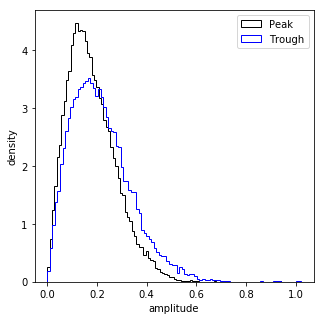

In [23]:
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(abs(x_a_gamma[peak_inds]), 100, color='k',density=True, histtype='step', label='Peak');
plt.hist(abs(x_a_gamma[trough_inds]), 100, color='b',density=True, histtype='step', label='Trough');
plt.xlabel('amplitude');plt.ylabel('density')
plt.legend()

(0, 2)

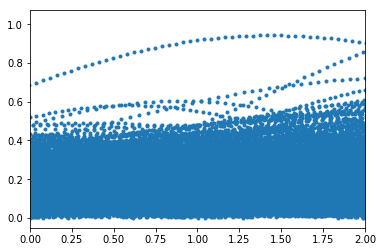

In [97]:
plt.plot(theta_phase,abs(x_a_gamma),'.')
plt.xlim(0,2)

# Time-Series Coupling in General
Congrats! You successfully implemented phase-amplitude coupling analysis above, which is one of several types of cross-frequency coupling that is hypothesized to exist in the brain, the others include, for example, amplitude-amplitude, phase-phase, and phase-frequency coupling. 

In addition, it's very common to compute coupling metrics for a pair of channels, such as their phase coupling at the same frequency, which tells you if an oscillation at two locations are synchronized with each other. We won't go into each method here, but they all use the same fundamental operation of bandpass filtering and computing a pair of analytic phase and/or amplitude, and see if certain values in one is correlated to values in the other in some way. 

More generally, this method can be applied to any time series, or any pair of time series, as long as they are sampled at the same sampling frequency.

---

# [7] Q4: Spike Train & Spike-Triggered Average (STA)

![](./img/spike_lfp.png)
The second half of this lab will make use of the spike train data as well. We will have gone over the concept of spike sorting in class, so I won't go into detail here. In this dataset, `spike_indices` has the **times indices (not time stamps)** of the action potentials (spikes) of well-isolated cells recorded on the same electrodes. 

We can't use it directly yet, however, since those indices has a different sampling frequency, stored in the variable `spike_fs`. This is typically the case since spike timing is much more precise than LFP data is required to be, so sub-millisecond resolution is optimal. Here, the spike indices are sampled at 20000Hz. I print the index number of the 100th spike, which is 45607, corresponding to a spike timing of 2.28035s. In this problem, we will first convert the spike indices to be at the same sampling rate as the LFP, then use it to compute spike triggered average of the LFP.

---
[1] Q4.1: Convert all spike indices into spike times (in seconds) following the logic above, and store in the variable `spike_times`.

[1] Q4.2: Using the spike times vector, find the closest corresponding LFP indices. Note that this is very similar to what you did in A1 to find the stimulus onset indices for computing the ERP. However, in this case, the spike timing will not result in exact integers when converted to LFP indices, since they have a finer time resolution. Use `np.round()` to find the **closest** index instead. You can do this in one line. Store it in the variable `spike_lfp_inds`, and remember to make them integers.

[2] Q4.3: Complete the function `get_windows()` to grab a window of data around each index and and store that in a 2D numpy matrix. Note that this is the exact same function as `get_all_epochs()` from A1, just without the intermediate step of `get_epoch()` explicitly written out (which you can get by without explicitly writing a function for). Following the same convention, `len_pre` is how many seconds of data to grab to the left of the index, and should be negative, and `len_post` is how much data to the right. **You can literally paste over your functions from A1, with one modification:** the first few spike times occur very early, so that there isn't enough data to the left to grab a full window. Similarly, the last few spikes occur with not enough data to the right to grab a full window. You need to put in a check to make sure that you can grab a full window around the provided index.

[1] Q4.4: Use `get_windows()` to grab windows of the **full LFP data (in the variable `lfp`)** around all spikes, with `len_pre=-0.5` and `len_post=0.5`, and store that in the variable `STA_windows`. This should return a 2D numpy array with dimensions [95367x1250].

[1] Q4.5: Compute the spike-triggered average (STA), which is averaging `STA_windows` across the spike dimensions (rows). Plot the STA, note that the x-axis should be in units of seconds. I plot a dashed line for you denoting the trigger point at 0, which are the reference points (spikes).

[1] Q4.6: Spike-triggered average is a crude way of seeing if there is a systematic relationship between the LFP and the spike times of the neuron. If they have no relationship, then the STA should average out to zero because there is no consistent temporally-locked pattern. On the other hand, if the STA is not a flat line, that implies LFP-modulated spike timing. Describe in words what your plot looks like, and what your interpretation is, in particular with respect to the theta oscillation.

**Response for 4.6:** The line looks like a symmetric set of waves that increases in the middle and then decreases towards the end. This implies LFP-modulated spike timing. 

In [25]:
lfp_fs = fs # rename lfp_fs to avoid confusion
# use the full LFP vector now
print(len(lfp))

# get spike information
spike_fs = data['spike_fs']
spike_indices = data['spike_indices']
print(spike_fs, spike_indices[100])

# convert spike index to spike time in seconds
spike_times = spike_indices / spike_fs
spike_lfp_inds = (np.round(spike_times*lfp_fs,decimals = 0))

1325125
20000 45607


In [36]:
def get_windows(data, spike_lfp_inds, lfp_fs, len_pre, len_post):
    windows = list()
    for index in spike_lfp_inds:
        if index + lfp_fs*len_pre >= 0 and index + len_post*lfp_fs <= len(data):
            start = int(index + int(len_pre*lfp_fs))
            end = int(index + int(len_post*lfp_fs))
            window = data[int(start):int(end)]
            windows.append(window)
    return np.array(windows)

len_pre = -0.5
len_post = 0.5

# time vector for STA
t_STA = np.arange(len_pre,len_post, 1/lfp_fs)
STA_windows = get_windows(lfp,spike_lfp_inds,lfp_fs,len_pre,len_post)
STA = np.mean(STA_windows, axis = 0)
#print(STA.shape)
print(STA_windows.shape)
#print(spike_times.shape)

(95367, 1250)


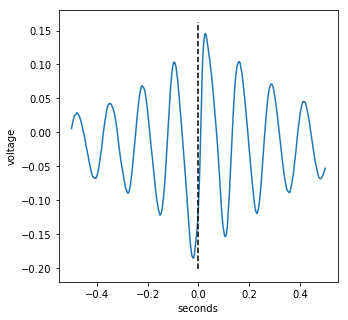

In [37]:
# plot STA
plt.figure(figsize=(5,5))
plt.xlabel("seconds");plt.ylabel("voltage")
plt.plot(t_STA, STA, label = "STA")
plt.plot([0,0], plt.ylim(), 'k--')

# [6 + 2 Bonus] Q5: Spike-Field Coherence & Preferred Phase
A more frequency-specific way of measuring the interaction between spike timing and LFP is to look at the phase distribution at spike times. Instead of collecting windows of the broadband LFP data, we can look at the theta oscillation and whether its phase is consistently related to spike timing. At the core of it, we are computing a histogram: at every spike time, we can look up the bandpassed signal's phase using the corresponding index in `spike_lfp_indices`, and we simply array-index all those phases and make a histogram to see if they are uniformly distributed as a function of phase. If spikes are equally likely to occur at all phases, that means the phase of that frequency has no relationship with spike timing. On the other hand, if the distribution is anything but uniform, then we can infer that spikes preferentially occur at certain phases.

[1] 5.1: Compute the theta analytic power and phase again, but use the full lfp signal `lfp`, instead of `lfp_short`. This means re-filtering your LFP for the theta oscillation using the same FIR filter `FIR_theta`. The data is a lot longer, so `signal.hilbert()` can take a second to run. Your `my_hilbert()` might actually be faster, for some very strange `scipy` reason.

[1] 5.2: Using array-indexing and `spike_lfp_inds` you computed from above, retrieve just the phases corresponding to when a spike has occurred. Store that in the variable `spike_theta_phases`.

[1] 5.3: I plot for you the distribution of theta phases at which a spike occurs. Label the x and y axes appropriately. Which phase are spikes most likely to occur at, and how does that relate to what you see in Q4.6?

[2] 5.4: Repeat 5.1-3 for the gamma oscillation, for the full LFP data, using FIR_gamma. Plot the histogram (copy and paste the line I write for you and change the variable). Comment on whether and how gamma oscillation is related to spiking timing. If so, how does the modulation strength and preferred phase compare to that of the theta oscillation?

[BONUS 2] 5.5: Produce a rose plot (polar histogram) for both the theta and gamma spike-phase distributions. You may wish to follow this [example](https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/polar_bar.html).

[1] 5.6: Spike Field Coherence (SFC) is technically defined as the power spectrum of the STA. Compute this and plot it in frequency domain, zoom into 0-50Hz. You could plot this using a linear or log-scaled y-axis.

**Response for 5.3:** ANSWER

**Response for 5.4:** ANSWER

-1.5707963267948966


<Figure size 360x360 with 0 Axes>

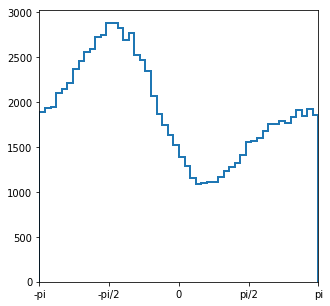

<Figure size 360x360 with 0 Axes>

In [42]:
# _FILL_IN_YOUR_CODE_HERE
analytic_theta = np.convolve(lfp, FIR_theta, mode='same')
analytic_theta = signal.hilbert(analytic_theta)
theta_power, theta_phase = compute_power_phase(analytic_theta)


# _FILL_IN_YOUR_CODE_HERE
gamma_power, gamma_phase = compute_power_phase(signal.hilbert(np.convolve(lfp, FIR_gamma, mode='same')))

spike_theta_phases = theta_phase[(spike_lfp_inds).astype(int)]
spike_gamma_phases = gamma_phase[(spike_lfp_inds).astype(int)]

plt.figure(figsize=(5,5))

# use 50 phase bins to catalogue the spike-phases
theta_counts, phase_bins, _ = plt.hist(spike_theta_phases,50, histtype='step', lw=2, label='Theta')
plt.xlim([-np.pi, np.pi])
plt.xticks(np.arange(-np.pi,np.pi+0.1, np.pi/2), ['-pi','-pi/2','0','pi/2','pi'])
print(-np.pi/2)

# compute and plot SFC from STA
plt.figure(figsize=(5,5))

# [6 + 1 Bonus] Q6: Firing Rate & Power Correlation
For the last part, we will work with a binned spike vector. We currently have the spiking information stored in an array that corresponds to their spike times (in seconds) and the corresponding LFP index. This representation of the data is unlike the timeseries we've been working with (discrete signals sampled at **regular intervals**) and is harder to manipulate (but the upside is that spike times stored this way requires less memory). As such, we'll turn the spike times into a vector (spike counts) matching the length of the lfp signal, representing the same discrete time bins. The value at each index in the `spike_count` vector is the number of spikes that fell into that time bin. 

For example, if the binned spike train has a bin width of 1ms, then the first bin represents the time between [0, 1) ms, and if there are spikes with timestamps of 0.32ms, 0.59ms, and 0.9ms, then that 0th bin would get a value of 3, for 3 spikes. Hence, it's the **spike count** per time bin. In the following exercise, we will create a spike count vector, sampled at the same rate as the LFP, and perform several analyses using them.

[1] 6.1: `np.digitize()` returns an array that bins the values of the data `x` into the bin vector `bins`. Meaning, the variable `bin_indices` matches every single spike time (`spike_time`) to a time bin in `t_lfp`. Write code below that will iterate through every index in `bin_indices` and increase the corresponding element in `spike_count` by 1. This will create your spike count vector, and `spike_count[68]` should return 2.

[2] 6.2: The spike count vector is very noisy, and we are typically more interested in the firing rate, which is computed by smoothing (or taking the **moving average** of) the spike count vector with a window function, usually a Gaussian window that integrates (sums) to 1. Create a 200-ms long Gaussian window, with a standard deviation of 40-ms, using `signal.windows` (you will have to convert those lengths in time into number of samples using `lfp_fs`). Normalize the Gaussian window such that it sums to 1, and convolve it with your spike count vector. Make sure that `mode='same'`. This is your firing rate vector.

[1] 6.3: Plot your firing rate vector, as well as theta power (on the same plot), and label appropriately. Zoom into the first 60 seconds. Comment on any similarity/differences between the traces.

[1] 6.4: Now you have two time series, the firing rate vector and the theta power vector. Often times, the log10 power is used instead of log power, so compute the log10 transform of theta power and save that in `log_theta_power`. Plot log theta power (y-axis) as a function of firing rate (x-axis), since they have the same number of points. Describe what you see, whether they are related, and how this compares to your response for 6.3.

[1] 6.5: Using `np.corrcoef()`, compute the Pearson correlation coefficient between the log10 theta power and firing rate (read the documentation if you're unsure what the output is). Is this consistent with your response for 6.3&4, and what interpretations can you make about this observation?

[BONUS 1] 6.6: An action potential has a refractory period, so the same neuron typically cannot fire more than once within 1ms. Given that, do you think the the spike times in this dataset came from one neuron? Support your answer.

**Response for 6.3:** ANSWER

**Response for 6.4:** ANSWER

**Response for 6.5:** ANSWER

In [ ]:
t_lfp = np.arange(0,len(lfp)/lfp_fs, 1/lfp_fs) # time vector for the full LFP
bin_indices = np.digitize(spike_times, t_lfp)
# printing how many unique values there are in bin_indices, which is less than its length
# this means there are repeating values in bin_indices, i.e., multiple spikes that fell in the same time bin.
print(np.unique(bin_indices).shape, bin_indices.shape)

spike_count = np.zeros_like(lfp, dtype=int)
# iterate over bin_indices to populate your spike_count vector

for ind in bin_indices:
# _FILL_IN_YOUR_CODE_HERE

print(spike_count[68])

# create and normalize your gaussian window, then convolve to make firing rate
gauss_win = # _FILL_IN_YOUR_CODE_HERE
firing_rate = # _FILL_IN_YOUR_CODE_HERE

# plot the time series of firing rate and theta power
plt.figure(figsize=(15,4))


log_theta_power = # _FILL_IN_YOUR_CODE_HERE

# plot theta power as a function of firing rate
plt.figure(figsize=(5,5))
plt.plot( , , '.', ms=0.5, alpha=0.5) # plot theta power as a function of firing rate

# compute and print correlation coefficient


# Congratulations!
You have finished all the assignments for COGS118C, which means that you've successfully implemented many key analyses for neural signal processing! The set of analyses in this lab are especially advanced and commonly used, as they build on top of the fundamental ideas we've been learning, such as Fourier analysis and filtering. You have recreated one of the most impactful (and highly cited) human neuroscience papers of all time. Furthermore, we've waded into some prelimary spike analysis, looking at both spike timing and firing rate, and how they relate to oscillations in the LFP. 

I sincerely hope that these exercises have nudged you a little towards an interest in computational neuroscience, as you are all now well-equipped to handle electrophysiological data from human and animal experiments! Again, almost every lab in Cognitive Science, Psychology, and Neuroscience that record electrophysiological data here at UCSD will employ these tools for their analysis, and you now wield the tools to contribute at a high level.

# Bonus Content: Autocorrelation & Cross Correlation
In case you want to use the autocorrelation or cross-correlation analysis for your project, I implement it for you here. You can compute it with `np.convolve()`, but it takes a very long time for large datasets.

In [ ]:
# implementation of fast cross-correlation
# np.convolve will always compute for all lag times, which is unwieldy with a long signal
# we usually just want the first few lags
def xcorr(data1, data2, maxlag=100, zero_center=False):
    acf = np.zeros(maxlag)
    acf[0] = np.correlate(data1,data2)
    for lag in range(1,maxlag):
        acf[lag] = np.correlate(data1[:-lag],data2[lag:])
    
    acf /= acf[0]
    if zero_center: acf[0]=np.nan
    return acf

plt.figure(figsize=(15,5))
maxlag=int(fs)
t_ac = np.arange(0,maxlag/fs,1/fs)
plt.subplot(1,3,1)
plt.plot(t_ac, xcorr(lfp, lfp, maxlag, True), '.')
plt.title('LFP Autocorrelation')
plt.subplot(1,3,2)
plt.plot(t_ac, xcorr(spike_count, spike_count, maxlag, True), '.')
plt.title('Spike Count Autocorrelation')
plt.subplot(1,3,3)
plt.plot(t_ac, xcorr(spike_count, lfp, maxlag, True), '.')
plt.title('Spike Count-LFP Cross-correlation');

# End Survery
Please take a few minutes to fill out the following as it will help us to improve the following assignments & lectures.

# Content:
What was one thing you learned from this lab & associated lectures?

ANSWER: 

---
What was one thing that you still found confusing after the lab, and need clarification?

ANSWER:

# Style:
What was one thing you enjoyed about the formatting of this assignment (e.g., clarity, structure, guidance, etc.)?

ANSWER:

---
What was one thing that you thought could use improvements on?

ANSWER:


# Thank you!